In [1]:
# General imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import normalize

# Neurophox imports
from neurophox.numpy import RMNumpy
from neurophox.tensorflow import RM
from neurophox.ml.nonlinearities import cnorm, cnormsq

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
def normalize(X):
    return X / abs(X).mean(axis=0, keepdims=True)

### Preprocessing

In [4]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

def inputFFT(X_raw, X_test_raw, r):
    '''
        FTs the input images
    '''
    c = X_raw.shape[1] // 2

    # FTing the image data
    X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
    X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

    # Cropping out the outer pixels
    X_ft = X_ft[:, c-r:c+r, c-r-1:c+r]
    X_test_ft = X_test_ft[:, c-r:c+r, c-r-1:c+r]

    # Flatten image
    X_ft = X_ft.reshape(X_ft.shape[0], -1)
    X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

    # Normalizing
    X_ft = normalize(X_ft).astype(np.complex64)
    X_test_ft = normalize(X_test_ft).astype(np.complex64)
    return X_ft, X_test_ft

X_ft, X_test_ft = inputFFT(X_raw, X_test_raw, 2)

# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

In [5]:
X_ft.shape

(60000, 20)

### Modelling

Activation function formula:

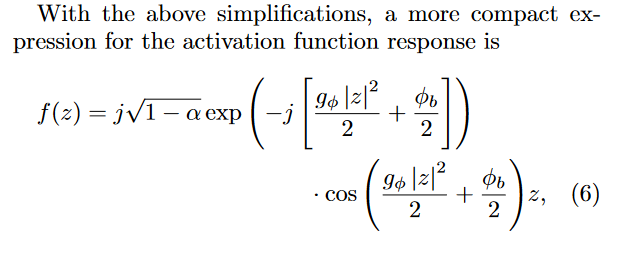

In [5]:
class EOIntensityModulation(tf.keras.layers.Layer):
    def __init__(self, N, alpha=0.1, g=np.pi, phi_b=np.pi, train_alpha=False, train_g=False, train_phi_b=False, single_param_per_layer=True):
        
        super(EOIntensityModulation, self).__init__()
        
        if single_param_per_layer:
            var_shape = [1]
        else:
            var_shape = [N]
        
        self.g = self.add_variable(shape=var_shape,
                                       name="g",
                                       initializer=tf.constant_initializer(g),
                                       trainable=train_g,
                                       constraint=lambda x: tf.clip_by_value(x, 1e-3, 1.5*np.pi))
        self.phi_b = self.add_variable(shape=var_shape,
                                       name="phi_b",
                                       initializer=tf.constant_initializer(phi_b),
                                       trainable=train_phi_b,
                                       constraint=lambda x: tf.clip_by_value(x, -np.pi, +np.pi))
        self.alpha = self.add_variable(shape=var_shape,
                                       name="alpha",
                                       initializer=tf.constant_initializer(alpha),
                                       trainable=train_alpha,
                                       constraint=lambda x: tf.clip_by_value(x, 0.01, 0.99))
    
    def call(self, inputs):
        alpha, g, phi_b = tf.complex(self.alpha, 0.0), tf.complex(self.g, 0.0), tf.complex(self.phi_b, 0.0)
        Z = inputs
        return 1j * tf.sqrt(1-alpha) * tf.exp(-1j*0.5*g*tf.math.conj(Z)*Z - 1j*0.5*phi_b) * tf.cos(0.5*g*tf.math.conj(Z)*Z + 0.5*phi_b) * Z

The procedure is summarised well by the following diagram.

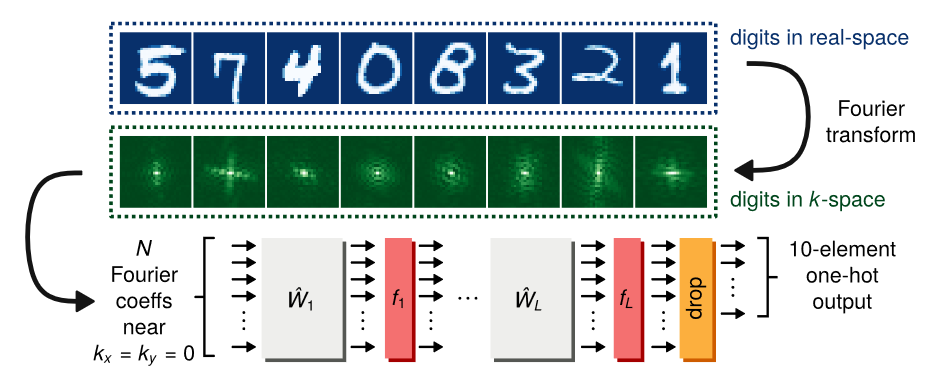

To get a better idea of the network layers -

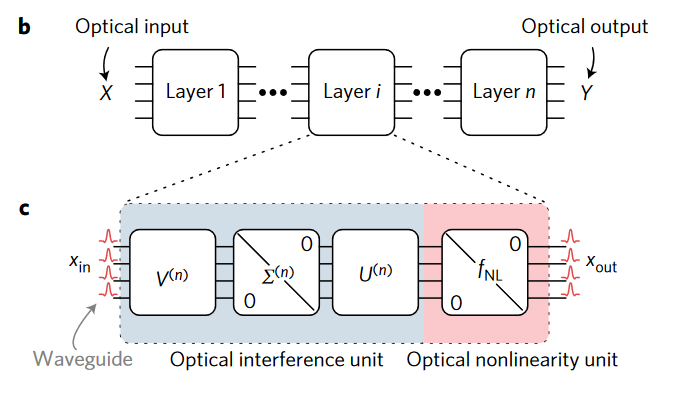

In [49]:
def generate_network(N, N_classes=10, L=1, theta_init_name='haar_rect', phi_init_name='random_phi', alpha=0.1, g=0.05*np.pi, phi_b=1*np.pi):
    """ Creates L layer ONN

    Args:
        N (int): Size of the input layer
        N_classes (int, optional): _description_. Defaults to 10.
        L (int, optional): _description_. Defaults to 1.
        theta_init_name (str, optional): _description_. Defaults to 'haar_rect'.
        phi_init_name (str, optional): _description_. Defaults to 'random_phi'.

    Returns:
        Sequential: _description_
    """
    layers=[]
    
    for _ in range(L):
        layers.append(RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name))
        # layers.append(EOIntensityModulation(N, alpha, g, phi_b))
    
    layers.append(Activation(cnormsq))
    layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
    layers.append(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
    # layers.append(tf.keras.layers.Softmax(axis=-1))

    return Sequential(layers)

In [50]:
epochs = 200
batch_size = 512
N_classes = 10

#### Simulating 64 modes with 3 layers

In [40]:
onn_model = generate_network(64, L=3)
onn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [8]:
history = onn_model.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 81s - loss: 0.0910 - accuracy: 0.2028 - val_loss: 0.0889 - val_accuracy: 0.2402 - 81s/epoch - 685ms/step
Epoch 2/200
118/118 - 34s - loss: 0.0781 - accuracy: 0.3034 - val_loss: 0.0731 - val_accuracy: 0.3253 - 34s/epoch - 288ms/step
Epoch 3/200
118/118 - 34s - loss: 0.0729 - accuracy: 0.3338 - val_loss: 0.0721 - val_accuracy: 0.3457 - 34s/epoch - 291ms/step
Epoch 4/200
118/118 - 41s - loss: 0.0699 - accuracy: 0.3685 - val_loss: 0.0646 - val_accuracy: 0.4128 - 41s/epoch - 349ms/step
Epoch 5/200
118/118 - 43s - loss: 0.0619 - accuracy: 0.4473 - val_loss: 0.0556 - val_accuracy: 0.4903 - 43s/epoch - 361ms/step
Epoch 6/200
118/118 - 42s - loss: 0.0544 - accuracy: 0.5232 - val_loss: 0.0483 - val_accuracy: 0.5959 - 42s/epoch - 359ms/step
Epoch 7/200
118/118 - 40s - loss: 0.0465 - accuracy: 0.6275 - val_loss: 0.0411 - val_accuracy: 0.6719 - 40s/epoch - 343ms/step
Epoch 8/200
118/118 - 34s - loss: 0.0345 - accuracy: 0.7360 - val_loss: 0.0310 - val_accuracy: 0.7574 - 34s/epo

#### Simulating the Quix QPP

20 modes with 1 layer

In [36]:
onn_model20_1 = generate_network(20, L=1)
onn_model20_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history20_1 = onn_model20_1.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 8s - loss: 0.1245 - accuracy: 0.2706 - val_loss: 0.0981 - val_accuracy: 0.4835 - 8s/epoch - 72ms/step
Epoch 2/200
118/118 - 3s - loss: 0.0870 - accuracy: 0.5654 - val_loss: 0.0770 - val_accuracy: 0.6488 - 3s/epoch - 29ms/step
Epoch 3/200
118/118 - 3s - loss: 0.0738 - accuracy: 0.6641 - val_loss: 0.0690 - val_accuracy: 0.7063 - 3s/epoch - 29ms/step
Epoch 4/200
118/118 - 3s - loss: 0.0678 - accuracy: 0.7061 - val_loss: 0.0646 - val_accuracy: 0.7355 - 3s/epoch - 27ms/step
Epoch 5/200
118/118 - 3s - loss: 0.0642 - accuracy: 0.7283 - val_loss: 0.0616 - val_accuracy: 0.7498 - 3s/epoch - 29ms/step
Epoch 6/200
118/118 - 3s - loss: 0.0615 - accuracy: 0.7441 - val_loss: 0.0593 - val_accuracy: 0.7596 - 3s/epoch - 28ms/step
Epoch 7/200
118/118 - 3s - loss: 0.0595 - accuracy: 0.7551 - val_loss: 0.0575 - val_accuracy: 0.7711 - 3s/epoch - 29ms/step
Epoch 8/200
118/118 - 4s - loss: 0.0578 - accuracy: 0.7652 - val_loss: 0.0560 - val_accuracy: 0.7808 - 4s/epoch - 31ms/step
Epoch 9/

In [37]:
print("Best epoch:", np.argmax(history20_1.history['val_accuracy']))
print("Best accuracy:", f"{max(history20_1.history['val_accuracy'])*100:.2f}%")

Best epoch: 186
Best accuracy: 84.96%


20 modes with 2 layers

In [17]:
onn_model20_2 = generate_network(20, L=2)
onn_model20_2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [18]:
history20_2 = onn_model20_2.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 18s - loss: 0.1080 - accuracy: 0.4041 - val_loss: 0.0779 - val_accuracy: 0.6205 - 18s/epoch - 150ms/step
Epoch 2/200
118/118 - 6s - loss: 0.0687 - accuracy: 0.6873 - val_loss: 0.0608 - val_accuracy: 0.7407 - 6s/epoch - 51ms/step
Epoch 3/200
118/118 - 6s - loss: 0.0581 - accuracy: 0.7572 - val_loss: 0.0540 - val_accuracy: 0.7844 - 6s/epoch - 49ms/step
Epoch 4/200
118/118 - 6s - loss: 0.0531 - accuracy: 0.7867 - val_loss: 0.0502 - val_accuracy: 0.8038 - 6s/epoch - 49ms/step
Epoch 5/200
118/118 - 6s - loss: 0.0500 - accuracy: 0.8044 - val_loss: 0.0478 - val_accuracy: 0.8170 - 6s/epoch - 49ms/step
Epoch 6/200
118/118 - 6s - loss: 0.0482 - accuracy: 0.8143 - val_loss: 0.0463 - val_accuracy: 0.8258 - 6s/epoch - 54ms/step
Epoch 7/200
118/118 - 6s - loss: 0.0470 - accuracy: 0.8213 - val_loss: 0.0454 - val_accuracy: 0.8328 - 6s/epoch - 53ms/step
Epoch 8/200
118/118 - 6s - loss: 0.0462 - accuracy: 0.8266 - val_loss: 0.0446 - val_accuracy: 0.8364 - 6s/epoch - 49ms/step
Epoch

In [35]:
print("Best epoch:", np.argmax(history20_2.history['val_accuracy']))
print("Best accuracy:", f"{max(history20_2.history['val_accuracy'])*100:.2f}%")

Best epoch: 152
Best accuracy: 85.96%


49 modes with 1 layer

In [38]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

def inputFFT(X_raw, X_test_raw, r):
    '''
        FTs the input images
    '''
    c = X_raw.shape[1] // 2

    # FTing the image data
    X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
    X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

    # Cropping out the outer pixels
    X_ft = X_ft[:, c-r-1:c+r, c-r-1:c+r]
    X_test_ft = X_test_ft[:, c-r-1:c+r, c-r-1:c+r]

    # Flatten image
    X_ft = X_ft.reshape(X_ft.shape[0], -1)
    X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

    # Normalizing
    X_ft = normalize(X_ft).astype(np.complex64)
    X_test_ft = normalize(X_test_ft).astype(np.complex64)
    return X_ft, X_test_ft

X_ft, X_test_ft = inputFFT(X_raw, X_test_raw, 3)

# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

In [40]:
onn_model49_1 = generate_network(49, L=1)
onn_model49_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history49_1 = onn_model49_1.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 18s - loss: 0.0985 - accuracy: 0.4624 - val_loss: 0.0641 - val_accuracy: 0.7065 - 18s/epoch - 156ms/step
Epoch 2/200
118/118 - 7s - loss: 0.0545 - accuracy: 0.7685 - val_loss: 0.0459 - val_accuracy: 0.8201 - 7s/epoch - 57ms/step
Epoch 3/200
118/118 - 7s - loss: 0.0438 - accuracy: 0.8324 - val_loss: 0.0398 - val_accuracy: 0.8541 - 7s/epoch - 55ms/step
Epoch 4/200
118/118 - 7s - loss: 0.0394 - accuracy: 0.8547 - val_loss: 0.0366 - val_accuracy: 0.8676 - 7s/epoch - 55ms/step
Epoch 5/200
118/118 - 6s - loss: 0.0369 - accuracy: 0.8647 - val_loss: 0.0347 - val_accuracy: 0.8767 - 6s/epoch - 55ms/step
Epoch 6/200
118/118 - 7s - loss: 0.0352 - accuracy: 0.8729 - val_loss: 0.0333 - val_accuracy: 0.8816 - 7s/epoch - 56ms/step
Epoch 7/200
118/118 - 6s - loss: 0.0339 - accuracy: 0.8785 - val_loss: 0.0323 - val_accuracy: 0.8876 - 6s/epoch - 54ms/step
Epoch 8/200
118/118 - 6s - loss: 0.0330 - accuracy: 0.8817 - val_loss: 0.0315 - val_accuracy: 0.8900 - 6s/epoch - 54ms/step
Epoch

In [41]:
print("Best epoch:", np.argmax(history49_1.history['val_accuracy']))
print("Best accuracy:", f"{max(history49_1.history['val_accuracy'])*100:.2f}%")

Best epoch: 127
Best accuracy: 91.80%


49 modes with 2 layers

In [42]:
onn_model49_2 = generate_network(49, L=2)
onn_model49_2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history49_2 = onn_model49_2.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 79s - loss: 0.0796 - accuracy: 0.5849 - val_loss: 0.0448 - val_accuracy: 0.8148 - 79s/epoch - 665ms/step
Epoch 2/200
118/118 - 16s - loss: 0.0384 - accuracy: 0.8499 - val_loss: 0.0332 - val_accuracy: 0.8782 - 16s/epoch - 133ms/step
Epoch 3/200
118/118 - 16s - loss: 0.0324 - accuracy: 0.8803 - val_loss: 0.0302 - val_accuracy: 0.8931 - 16s/epoch - 135ms/step
Epoch 4/200
118/118 - 16s - loss: 0.0305 - accuracy: 0.8894 - val_loss: 0.0290 - val_accuracy: 0.8999 - 16s/epoch - 135ms/step
Epoch 5/200
118/118 - 16s - loss: 0.0295 - accuracy: 0.8937 - val_loss: 0.0285 - val_accuracy: 0.9006 - 16s/epoch - 133ms/step
Epoch 6/200
118/118 - 16s - loss: 0.0289 - accuracy: 0.8966 - val_loss: 0.0277 - val_accuracy: 0.9050 - 16s/epoch - 136ms/step
Epoch 7/200
118/118 - 16s - loss: 0.0283 - accuracy: 0.8991 - val_loss: 0.0272 - val_accuracy: 0.9057 - 16s/epoch - 132ms/step
Epoch 8/200
118/118 - 16s - loss: 0.0279 - accuracy: 0.9013 - val_loss: 0.0268 - val_accuracy: 0.9072 - 16s/epo

In [43]:
print("Best epoch:", np.argmax(history49_2.history['val_accuracy']))
print("Best accuracy:", f"{max(history49_2.history['val_accuracy'])*100:.2f}%")

Best epoch: 141
Best accuracy: 91.73%


In [52]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

def inputFFT(X_raw, X_test_raw, r):
    '''
        FTs the input images
    '''
    c = X_raw.shape[1] // 2

    # FTing the image data
    X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
    X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

    # Cropping out the outer pixels
    X_ft = X_ft[:, c-r:c+r, c-r:c+r]
    X_test_ft = X_test_ft[:, c-r:c+r, c-r:c+r]

    # Flatten image
    X_ft = X_ft.reshape(X_ft.shape[0], -1)
    X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

    # Normalizing
    X_ft = normalize(X_ft).astype(np.complex64)
    X_test_ft = normalize(X_test_ft).astype(np.complex64)
    return X_ft, X_test_ft

X_ft, X_test_ft = inputFFT(X_raw, X_test_raw, 4)

# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

In [53]:
X_ft.shape

(60000, 64)

64 modes with 1 layer

In [54]:
onn_model64_1 = generate_network(64, L=1)
onn_model64_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history64_1 = onn_model64_1.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 23s - loss: 0.0905 - accuracy: 0.5121 - val_loss: 0.0541 - val_accuracy: 0.7520 - 23s/epoch - 192ms/step
Epoch 2/200
118/118 - 7s - loss: 0.0466 - accuracy: 0.7977 - val_loss: 0.0389 - val_accuracy: 0.8441 - 7s/epoch - 63ms/step
Epoch 3/200
118/118 - 8s - loss: 0.0374 - accuracy: 0.8513 - val_loss: 0.0337 - val_accuracy: 0.8729 - 8s/epoch - 65ms/step
Epoch 4/200
118/118 - 7s - loss: 0.0335 - accuracy: 0.8725 - val_loss: 0.0309 - val_accuracy: 0.8884 - 7s/epoch - 63ms/step
Epoch 5/200
118/118 - 7s - loss: 0.0313 - accuracy: 0.8826 - val_loss: 0.0295 - val_accuracy: 0.8929 - 7s/epoch - 63ms/step
Epoch 6/200
118/118 - 7s - loss: 0.0299 - accuracy: 0.8891 - val_loss: 0.0285 - val_accuracy: 0.8994 - 7s/epoch - 62ms/step
Epoch 7/200
118/118 - 7s - loss: 0.0290 - accuracy: 0.8932 - val_loss: 0.0276 - val_accuracy: 0.9017 - 7s/epoch - 62ms/step
Epoch 8/200
118/118 - 7s - loss: 0.0283 - accuracy: 0.8960 - val_loss: 0.0270 - val_accuracy: 0.9038 - 7s/epoch - 63ms/step
Epoch

In [56]:
print("Best epoch:", np.argmax(history64_1.history['val_accuracy']))
print("Best accuracy:", f"{max(history64_1.history['val_accuracy'])*100:.2f}%")

Best epoch: 184
Best accuracy: 92.30%


| Input Dim (N) | No. of Mesh Layers (L) | Epochs | Test Acc |
|:-------------:|:----------------------:|:------:|:--------:|
|       64      |            2           |   100  |    96    |
|       64      |            3           |   200  |   97.38  |
|       64      |            4           |   200  |          |



---

### Multicore PNN

In [ ]:
def generate_network_multicore(N, N_classes=10, L=1, theta_init_name='haar_rect', phi_init_name='random_phi', alpha=0.1, g=0.05*np.pi, phi_b=1*np.pi):
    """ Creates L layer ONN

    Args:
        N (int): Size of the input layer
        N_classes (int, optional): _description_. Defaults to 10.
        L (int, optional): _description_. Defaults to 1.
        theta_init_name (str, optional): _description_. Defaults to 'haar_rect'.
        phi_init_name (str, optional): _description_. Defaults to 'random_phi'.

    Returns:
        Sequential: _description_
    """
    layers=[]
    
    for _ in range(L):
        layers.append(RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name))
        # layers.append(EOIntensityModulation(N, alpha, g, phi_b))
    
    layers.append(Activation(cnormsq))
    layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
    layers.append(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
    # layers.append(tf.keras.layers.Softmax(axis=-1))

    return Sequential(layers)

---
### Playing around with mesh layers

N = 64

Number of MZIs = 2016 per layer

L = 2

Total = 4032 MZIs



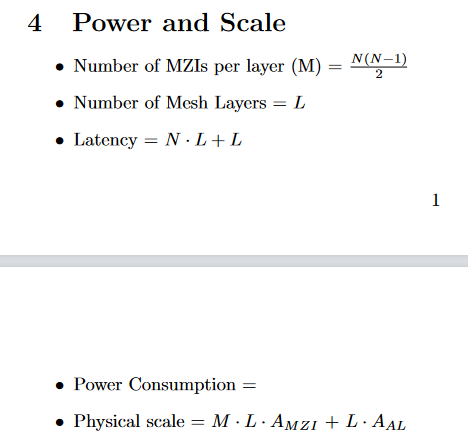

In [57]:
tf_layer = RM(20) # Implicitly sets the number of MZI 'layers' to N when not specified.

In [58]:
tf_layer.plot(plt)

: 

: 

In [3]:
nplayer = RMNumpy(5)

In [ ]:
nplayer.transform(np.array([1,0,0,0,0]).reshape(5, 1))

array([[-0.04305539+0.54792187j, -0.19603391-0.33263207j,
         0.05534905+0.47113741j,  0.15567604-0.46370971j,
         0.1978381 -0.21311702j]])

: 

: 

In [5]:
plt.figure(dpi=200, figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.abs(layer.propagate(np.eye(5)[2]).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title('Propagation for Haar random $\\theta_{n\ell}$')

ValueError: operands could not be broadcast together with shapes (4,) (1,5) 

: 

: 